In [1]:
import pandas as pd

import graphviz

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [2]:
df = pd.read_csv('../../results/best_matches_v7_1000bp.tsv', sep='\t')
total_contigs = len(df)
print(f'{len(df)} total contigs')
df

16829 total contigs


,name,method,contig,contig_len,wp_alignment_id,pf_alignment_id,wp_query_length,wp_ref_length,pf_ref_length,wp_percent_identity,...,wp_query_end,wp_subj_start,wp_subj_end,all_pf_alignment_id,all_pf_ref_length,all_pf_percent_identity,all_pf_coverage_percentage,all_pf_plasmid_name,all_pf_query_end,all_pf_query_start
0,URI47,shortread,NODE_1_length_463767_cov_77.611941,463767,CP124080.1,NaN,463767.0,907764.0,NaN,99.969427,...,463767,904797.0,440971.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,URI47,shortread,NODE_2_length_221463_cov_78.896272,221463,CP124080.1,NaN,221463.0,907764.0,NaN,99.096842,...,221463,435078.0,213616.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,URI47,shortread,NODE_3_length_213568_cov_76.158203,213568,CP094579.1,NaN,213568.0,920773.0,NaN,99.974041,...,213232,213232.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,URI47,shortread,NODE_4_length_53880_cov_109.176347,53880,CP124079.1,B31_lp54,53880.0,53843.0,30964.0,97.234499,...,53842,53842.0,1.0,B31_lp54_ParA_1,30964.0,100.0,99.600000,lp54,40231.0,39482.0
4,URI47,shortread,NODE_5_length_39870_cov_168.736612,39870,CP094594.1,B31_lp36,39870.0,31386.0,30964.0,99.547302,...,39870,1.0,19782.0,B31_lp36_ParA_1,30964.0,100.0,97.188755,lp36,8883.0,8155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16824,URI93H,longread,contig000025,160,NaN,NaN,NaN,NaN,NaN,NaN,...,1007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16825,URI93H,longread,contig000026,151,NaN,NaN,NaN,NaN,NaN,NaN,...,1007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16826,URI93H,longread,contig000027,148,NaN,NaN,NaN,NaN,NaN,NaN,...,1007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16827,URI93H,longread,contig000028,119,NaN,NaN,NaN,NaN,NaN,NaN,...,1007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Level 1: shorter than 25kb

In [3]:
passing_length = df['contig_len']>2500
too_short = df[~passing_length]
df = df[passing_length]
print(f'Dropout 1 size: {len(too_short)}')
print(f'Remaining # contigs: {len(df)}')

Dropout 1 size: 13630
Remaining # contigs: 3199


#### Level 2: No pf32

In [4]:
pf_isna = (df['pf_plasmid_name'].isna()) | (df['all_pf_plasmid_name'].isna())
no_pf = df[pf_isna]
df = df[~pf_isna]
print(f'Dropout 2 size: {len(no_pf)}')
print(f'Remaining # contigs: {len(df)}')

Dropout 2 size: 1624
Remaining # contigs: 1575


#### Level 3: All agree?

In [5]:
all_agree = (df['wp_plasmid_name'] == df['pf_plasmid_name']) & \
            (df['all_pf_plasmid_name'] == df['pf_plasmid_name']) & \
            (df['all_pf_plasmid_name'] == df['wp_plasmid_name'])
all_agree_df = df[all_agree]
df = df[~all_agree]
print(f'Dropout 3: {len(all_agree_df)}')
print(f'Remaining # contigs to be handled: {len(df)}')

Dropout 3: 1336
Remaining # contigs to be handled: 239


#### Handle disagreements

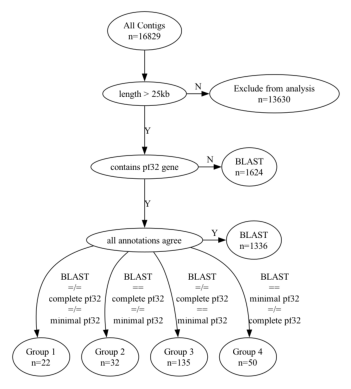

In [6]:
group1=\
df[(df['wp_plasmid_name'] != df['pf_plasmid_name']) & 
   (df['all_pf_plasmid_name'] != df['pf_plasmid_name']) &
   (df['all_pf_plasmid_name'] != df['wp_plasmid_name'])]

group2=\
df[(df['wp_plasmid_name'] != df['pf_plasmid_name']) & 
   (df['all_pf_plasmid_name'] != df['pf_plasmid_name']) &
   (df['all_pf_plasmid_name'] == df['wp_plasmid_name'])]

group3=\
df[(df['wp_plasmid_name'] != df['pf_plasmid_name']) & 
   (df['all_pf_plasmid_name'] == df['pf_plasmid_name']) &
   (df['all_pf_plasmid_name'] != df['wp_plasmid_name'])]

group4=\
df[(df['wp_plasmid_name'] == df['pf_plasmid_name']) & 
   (df['all_pf_plasmid_name'] != df['pf_plasmid_name']) &
   (df['all_pf_plasmid_name'] != df['wp_plasmid_name'])]

# Create a new Digraph
dot = graphviz.Digraph(comment='Stacked Flowchart')

# Add nodes
dot.node('allcontigs', f'All Contigs\nn={total_contigs}')
dot.node('filter1', 'length > 25kb')
dot.node('filter2', 'contains pf32 gene')
dot.node('filter3', 'all annotations agree')
dot.node('match1', f'Group 1\nn={len(group1)}')
dot.node('match2', f'Group 2\nn={len(group2)}')
dot.node('match3', f'Group 3\nn={len(group3)}')
dot.node('match4', f'Group 4\nn={len(group4)}')
dot.node('dropout1', f'Exclude from analysis\nn={len(too_short)}')
dot.node('dropout2', f'BLAST\nn={len(no_pf)}')
dot.node('dropout3', f'BLAST\nn={len(all_agree_df)}')

# Add edges
dot.edge('allcontigs', 'filter1')
dot.edge('filter1', 'filter2', label='Y')
dot.edge('filter2', 'filter3', label='Y')
dot.edge('filter3', 'match1', label='BLAST\n=/=\ncomplete pf32\n=/=\nminimal pf32')
dot.edge('filter3', 'match2', label='BLAST\n==\ncomplete pf32\n=/=\nminimal pf32')
dot.edge('filter3', 'match3', label='BLAST\n=/=\ncomplete pf32\n==\nminimal pf32')
dot.edge('filter3', 'match4', label='BLAST\n==\nminimal pf32\n=/=\ncomplete pf32')

# Apply rank constraints to keep 1, 2, 3, 4 aligned vertically
with dot.subgraph() as s:
    s.attr(rank='same')
    s.edge('filter1', 'dropout1', label='N')
with dot.subgraph() as s:
    s.attr(rank='same')
    s.edge('filter2', 'dropout2', label='N')
with dot.subgraph() as s:
    s.attr(rank='same')
    s.edge('filter3', 'dropout3', label='Y')

    

# Save and render the graph
dot.render('stacked_flowchart', format='png')

img = mpimg.imread('stacked_flowchart.png')
plt.imshow(img);
plt.axis('off');

Group 1 I do not know how to handle.

Group 2 I know how to handle - I argue that if a pf32 gene is present and the complete pf32 classification aligns with the BLAST classification, then the reason that the minimal pf32 classification didn't agree is likely because it did not have access to this plasmid. In this case, we should use the BLAST / complete pf32 classification.

Group 3 I do not know how to handle.

Group 4 I do not know how to handle.

Groups 3 and 4 are the largest subsets and represent occasions where BLAST and complete pf32 disagree. (This is also captured by Group 1.) This yields:

In [38]:
print(f"Times when BLAST and complete pf32 disagree: {len(df[df['wp_plasmid_name']!=df['all_pf_plasmid_name']])}")
print(f"Times when BLAST and minimal pf32 disagree: {len(df[df['wp_plasmid_name']!=df['pf_plasmid_name']])}")
print(f"Times when minimal pf32 and complete pf32 disagree: {len(df[df['all_pf_plasmid_name']!=df['pf_plasmid_name']])}")

Times when BLAST and complete pf32 disagree: 207
Times when BLAST and minimal pf32 disagree: 189
Times when minimal pf32 and complete pf32 disagree: 104


## Analysis of group 1

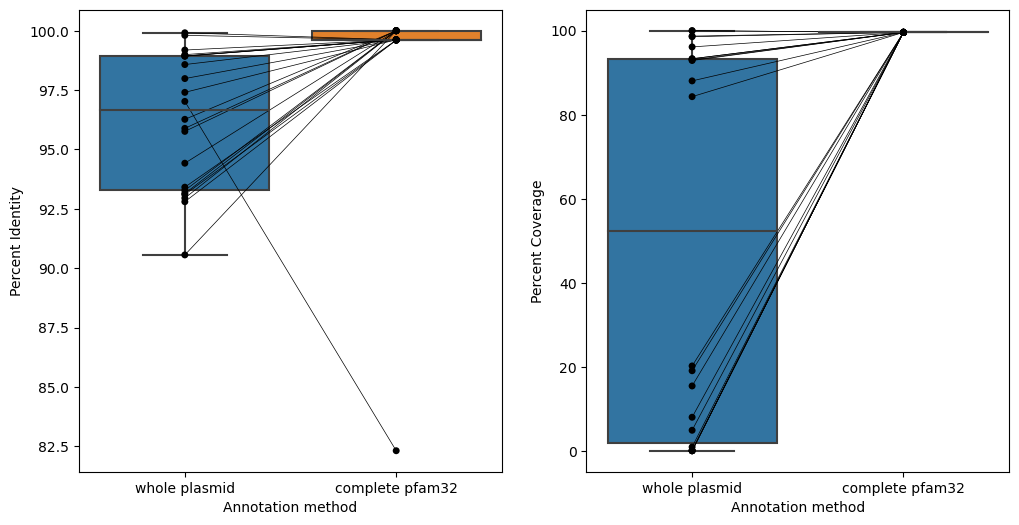

In [70]:
temp1 = group1.melt(id_vars=['name', 'contig'], 
                   value_vars=['wp_percent_identity', 'pf_percent_identity'], 
                   var_name='Annotation method', 
                   value_name='Percent Identity')
temp1['Annotation method'] = temp1['Annotation method'].apply(lambda x: 'whole plasmid' if 'wp' in x else 'complete pfam32')

temp2 = group1.melt(id_vars=['name', 'contig'], 
                   value_vars=['wp_coverage_percentage', 'pf_coverage_percentage'], 
                   var_name='Annotation method', 
                   value_name='Percent Coverage')
temp2['Annotation method'] = temp2['Annotation method'].apply(lambda x: 'whole plasmid' if 'wp' in x else 'complete pfam32')

temp = pd.merge(temp1, temp2, on=['name', 'contig', 'Annotation method'])

temp = temp.melt(id_vars=['name', 'contig', 'Annotation method'],
                 value_vars=['Percent Identity', 'Percent Coverage'],
                 var_name='Metric',
                 value_name='Value')
temp.sort_values(by=['name', 'contig', 'Annotation method', 'Metric', 'Value'])


fig, axes = plt.subplots(1, 2, figsize=(12,6))
ax = axes[0]
sns.boxplot(x='Annotation method',
            y='Percent Identity',
            data=temp1,
            showfliers=False,
            ax=ax)
sns.stripplot(x='Annotation method',
            y='Percent Identity',
            data=temp1,
            jitter=False,
            color='black',
            ax=ax)
for _, row in temp1[['name','contig']].drop_duplicates().iterrows():
    y1=temp1[
        (temp1['name']==row['name']) & 
        (temp1['contig']==row['contig']) & 
        (temp1['Annotation method']=='whole plasmid')]['Percent Identity'].item()
    y2=temp1[
        (temp1['name']==row['name']) & 
        (temp1['contig']==row['contig']) & 
        (temp1['Annotation method']=='complete pfam32')]['Percent Identity'].item()
    ax.plot([0, 1], [y1, y2], linestyle='-', color='black', linewidth=0.5)
ax = axes[1]
sns.boxplot(x='Annotation method',
            y='Percent Coverage',
            data=temp2,
            showfliers=False,
            ax=ax)
sns.stripplot(x='Annotation method',
            y='Percent Coverage',
            data=temp2,
            jitter=False,
            color='black',
            ax=ax);
for _, row in temp2[['name','contig']].drop_duplicates().iterrows():
    y1=temp2[
        (temp2['name']==row['name']) & 
        (temp2['contig']==row['contig']) & 
        (temp2['Annotation method']=='whole plasmid')]['Percent Coverage'].item()
    y2=temp2[
        (temp2['name']==row['name']) & 
        (temp2['contig']==row['contig']) & 
        (temp2['Annotation method']=='complete pfam32')]['Percent Coverage'].item()
    ax.plot([0, 1], [y1, y2], linestyle='-', color='black', linewidth=0.5)

In [114]:
group1[group1['pf_plasmid_name']=='lp21'
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,URI111,2725,chromosome,lp21-cp9,lp21,98.993808,0.142218,99.618321,99.618321
1,URI40,2740,chromosome,lp21-cp9,lp21,98.928845,0.143870,99.618321,99.618321
2,UCT29,2749,chromosome,lp21-cp9,lp21,98.936170,0.144861,99.618321,99.618321
3,URI56,2789,chromosome,lp21-cp9,lp21,98.936978,0.144972,99.618321,99.618321
4,URI89,2765,chromosome,lp21-cp9,lp21,98.575712,0.146844,99.618321,99.618321
5,UNY149,5960,chromosome,lp21-cp9,lp21,97.986131,1.026637,99.618321,99.618321
6,URI46,8348,lp28-1,lp21-cp9,lp21,99.913607,19.160561,99.618321,99.618321
7,URI112H,71363,lp28-3,lp21-cp9,lp21,97.025057,98.581758,82.318271,99.618321
8,UNY193,4282,lp28-5,lp21-cp9,lp21,97.405190,8.101081,99.618321,99.618321
9,URI46H,64384,lp28-5,lp21-cp9,lp21,99.805329,99.996386,99.618321,99.618321


In [90]:
group1[group1['pf_plasmid_name']=='cp32-13'
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,URI34,8338,cp32-1,lp28-9,cp32-13,93.276624,20.295744,100.0,99.606299
1,UNY203,6776,cp32-10,lp28-9,cp32-13,92.952949,15.540227,100.0,99.606299
2,UNY193P,30779,cp32-11,lp28-9,cp32-13,95.762416,93.324197,100.0,99.606299
3,URI34H,30920,cp32-11,lp28-9,cp32-13,94.422477,93.327460,100.0,99.606299
4,UNY193,2910,cp32-5,lp28-9,cp32-13,90.561798,5.005632,100.0,99.606299


In [89]:
group1[(group1['pf_plasmid_name']!='cp32-13') & (group1['pf_plasmid_name']!='lp21')
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,UCT92H,30910,cp32-12,cp32-5-1,cp32-1,95.889719,96.145603,100.000000,99.593496
1,UCT96H,30892,cp32-7,cp32-5-1,cp32-1,93.147648,93.051948,100.000000,99.593496
2,URI41H,60093,cp32-3,lp56,cp32-10,96.269725,99.996691,100.000000,99.601594
3,URI48H,30219,cp32-9,lp56,cp32-10,93.103448,88.070634,99.601594,99.601594
4,URI33H,30208,cp32-9-4,lp56,cp32-10,93.413196,84.321476,99.601594,99.601594
5,UCT35H,45523,cp32-10,cp32-6,cp32-4,92.800794,92.919075,99.601594,99.601594


## Analysis of group 2

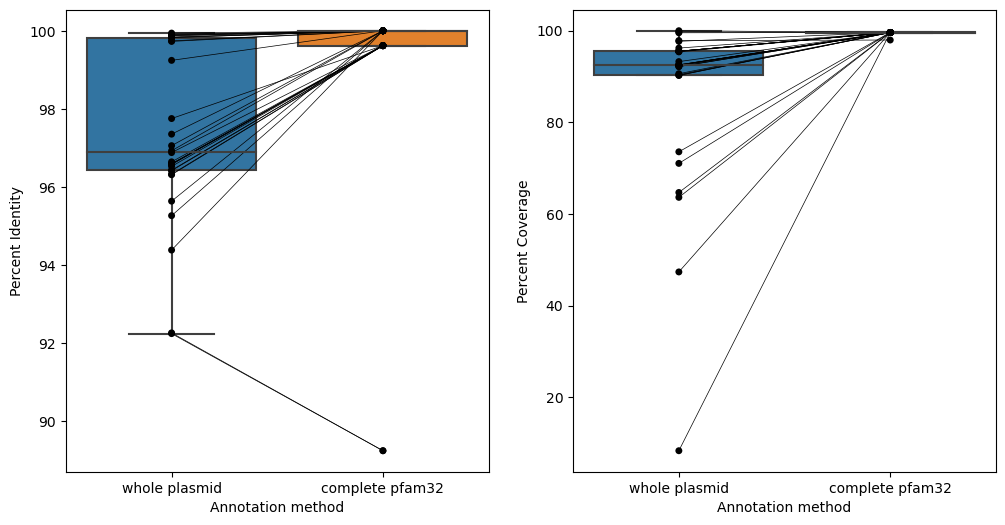

In [71]:
temp1 = group2.melt(id_vars=['name', 'contig'], 
                   value_vars=['wp_percent_identity', 'pf_percent_identity'], 
                   var_name='Annotation method', 
                   value_name='Percent Identity')
temp1['Annotation method'] = temp1['Annotation method'].apply(lambda x: 'whole plasmid' if 'wp' in x else 'complete pfam32')

temp2 = group2.melt(id_vars=['name', 'contig'], 
                   value_vars=['wp_coverage_percentage', 'pf_coverage_percentage'], 
                   var_name='Annotation method', 
                   value_name='Percent Coverage')
temp2['Annotation method'] = temp2['Annotation method'].apply(lambda x: 'whole plasmid' if 'wp' in x else 'complete pfam32')

temp = pd.merge(temp1, temp2, on=['name', 'contig', 'Annotation method'])

temp = temp.melt(id_vars=['name', 'contig', 'Annotation method'],
                 value_vars=['Percent Identity', 'Percent Coverage'],
                 var_name='Metric',
                 value_name='Value')
temp.sort_values(by=['name', 'contig', 'Annotation method', 'Metric', 'Value'])


fig, axes = plt.subplots(1, 2, figsize=(12,6))
ax = axes[0]
sns.boxplot(x='Annotation method',
            y='Percent Identity',
            data=temp1,
            showfliers=False,
            ax=ax)
sns.stripplot(x='Annotation method',
            y='Percent Identity',
            data=temp1,
            jitter=False,
            color='black',
            ax=ax)
for _, row in temp1[['name','contig']].drop_duplicates().iterrows():
    y1=temp1[
        (temp1['name']==row['name']) & 
        (temp1['contig']==row['contig']) & 
        (temp1['Annotation method']=='whole plasmid')]['Percent Identity'].item()
    y2=temp1[
        (temp1['name']==row['name']) & 
        (temp1['contig']==row['contig']) & 
        (temp1['Annotation method']=='complete pfam32')]['Percent Identity'].item()
    ax.plot([0, 1], [y1, y2], linestyle='-', color='black', linewidth=0.5)
ax = axes[1]
sns.boxplot(x='Annotation method',
            y='Percent Coverage',
            data=temp2,
            showfliers=False,
            ax=ax)
sns.stripplot(x='Annotation method',
            y='Percent Coverage',
            data=temp2,
            jitter=False,
            color='black',
            ax=ax);
for _, row in temp2[['name','contig']].drop_duplicates().iterrows():
    y1=temp2[
        (temp2['name']==row['name']) & 
        (temp2['contig']==row['contig']) & 
        (temp2['Annotation method']=='whole plasmid')]['Percent Coverage'].item()
    y2=temp2[
        (temp2['name']==row['name']) & 
        (temp2['contig']==row['contig']) & 
        (temp2['Annotation method']=='complete pfam32')]['Percent Coverage'].item()
    ax.plot([0, 1], [y1, y2], linestyle='-', color='black', linewidth=0.5)

In [88]:
group2[group2['pf_plasmid_name']=='cp32-10'
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,ESI26H,27753,cp32-3+10,cp32-3+10,cp32-10,92.242535,92.420279,89.243028,99.601594
1,ESI26,27851,cp32-3+10,cp32-3+10,cp32-10,92.261137,92.428583,89.243028,99.601594
2,URI41,4718,lp56,lp56,cp32-10,97.351143,8.329086,100.000000,99.601594
3,URI40H,25083,lp56,lp56,cp32-10,99.840529,47.350437,100.000000,99.601594
4,URI42H,57475,lp56,lp56,cp32-10,95.263582,63.631043,100.000000,99.601594
5,URI87H,34241,lp56,lp56,cp32-10,99.740184,64.688108,100.000000,99.601594
6,URI102H,37608,lp56,lp56,cp32-10,99.891015,71.043040,100.000000,99.601594
7,URI101H,47767,lp56,lp56,cp32-10,99.870277,90.255142,100.000000,99.601594
8,UCT29H,47767,lp56,lp56,cp32-10,99.899569,90.255142,100.000000,99.601594
9,URI93H,47855,lp56,lp56,cp32-10,99.939414,90.393005,100.000000,99.601594


In [87]:
group2[group2['pf_plasmid_name']=='lp21'
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,URI93H,28843,lp21-cp9,lp21-cp9,lp21,96.324399,73.567885,99.618321,99.618321
1,URI101H,29020,lp21-cp9,lp21-cp9,lp21,96.427375,93.258703,99.618321,99.618321
2,URI120H,26324,lp21-cp9,lp21-cp9,lp21,96.524834,95.378685,99.618321,99.618321
3,UCT31H,30338,lp21-cp9,lp21-cp9,lp21,96.594054,95.522204,99.618321,99.618321
4,URI111H,30763,lp21-cp9,lp21-cp9,lp21,96.580985,95.522204,99.618321,99.618321
5,URI89H,23058,lp21-cp9,lp21-cp9,lp21,97.750747,95.522204,99.618321,99.618321
6,URI39H,29953,lp21-cp9,lp21-cp9,lp21,96.586988,95.522204,99.618321,99.618321
7,URI41H,30141,lp21-cp9,lp21-cp9,lp21,96.573558,95.522204,99.618321,99.618321
8,UCT29H,29761,lp21-cp9,lp21-cp9,lp21,96.311935,95.522204,99.618321,99.618321
9,UCT30H,34559,lp21-cp9,lp21-cp9,lp21,96.879011,97.687292,99.618321,99.618321


In [86]:
group2[(group2['pf_plasmid_name']!='cp32-10') & (group2['pf_plasmid_name']!='lp21')
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,URI120H,30868,cp32-5-1,cp32-5-1,cp32-1,94.382002,96.208857,100.0,99.593496
1,ESI26H,61321,cp32-12,cp32-12,cp32-5,95.634673,99.996819,100.0,99.610895
2,ESI26,32476,lp28-4,lp28-4,lp17,96.926271,97.850920,100.0,97.967480


## Analysis of group 3

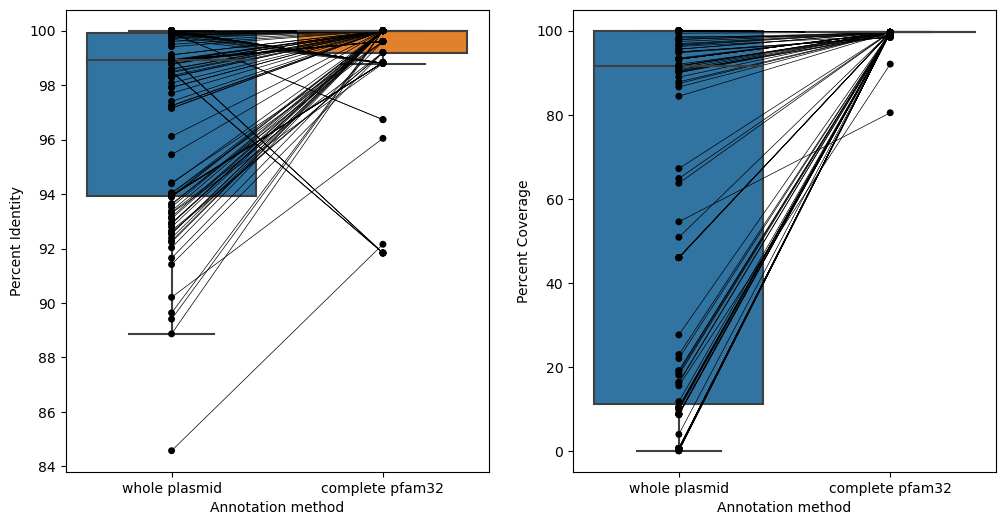

In [72]:
temp1 = group3.melt(id_vars=['name', 'contig'], 
                   value_vars=['wp_percent_identity', 'pf_percent_identity'], 
                   var_name='Annotation method', 
                   value_name='Percent Identity')
temp1['Annotation method'] = temp1['Annotation method'].apply(lambda x: 'whole plasmid' if 'wp' in x else 'complete pfam32')

temp2 = group3.melt(id_vars=['name', 'contig'], 
                   value_vars=['wp_coverage_percentage', 'pf_coverage_percentage'], 
                   var_name='Annotation method', 
                   value_name='Percent Coverage')
temp2['Annotation method'] = temp2['Annotation method'].apply(lambda x: 'whole plasmid' if 'wp' in x else 'complete pfam32')

temp = pd.merge(temp1, temp2, on=['name', 'contig', 'Annotation method'])

temp = temp.melt(id_vars=['name', 'contig', 'Annotation method'],
                 value_vars=['Percent Identity', 'Percent Coverage'],
                 var_name='Metric',
                 value_name='Value')
temp.sort_values(by=['name', 'contig', 'Annotation method', 'Metric', 'Value'])


fig, axes = plt.subplots(1, 2, figsize=(12,6))
ax = axes[0]
sns.boxplot(x='Annotation method',
            y='Percent Identity',
            data=temp1,
            showfliers=False,
            ax=ax)
sns.stripplot(x='Annotation method',
            y='Percent Identity',
            data=temp1,
            jitter=False,
            color='black',
            ax=ax)
for _, row in temp1[['name','contig']].drop_duplicates().iterrows():
    y1=temp1[
        (temp1['name']==row['name']) & 
        (temp1['contig']==row['contig']) & 
        (temp1['Annotation method']=='whole plasmid')]['Percent Identity'].item()
    y2=temp1[
        (temp1['name']==row['name']) & 
        (temp1['contig']==row['contig']) & 
        (temp1['Annotation method']=='complete pfam32')]['Percent Identity'].item()
    ax.plot([0, 1], [y1, y2], linestyle='-', color='black', linewidth=0.5)
ax = axes[1]
sns.boxplot(x='Annotation method',
            y='Percent Coverage',
            data=temp2,
            showfliers=False,
            ax=ax)
sns.stripplot(x='Annotation method',
            y='Percent Coverage',
            data=temp2,
            jitter=False,
            color='black',
            ax=ax);
for _, row in temp2[['name','contig']].drop_duplicates().iterrows():
    y1=temp2[
        (temp2['name']==row['name']) & 
        (temp2['contig']==row['contig']) & 
        (temp2['Annotation method']=='whole plasmid')]['Percent Coverage'].item()
    y2=temp2[
        (temp2['name']==row['name']) & 
        (temp2['contig']==row['contig']) & 
        (temp2['Annotation method']=='complete pfam32')]['Percent Coverage'].item()
    ax.plot([0, 1], [y1, y2], linestyle='-', color='black', linewidth=0.5)

In [92]:
group3[group3['pf_plasmid_name']=='cp32-7'
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,URI93,2711,cp32-2,cp32-7,cp32-7,100.000000,8.673388,100.0,99.598394
1,URI42,2757,cp32-2,cp32-7,cp32-7,100.000000,8.820611,100.0,99.598394
2,URI87,2766,cp32-2,cp32-7,cp32-7,100.000000,8.849416,100.0,99.598394
3,URI107,2766,cp32-2,cp32-7,cp32-7,100.000000,8.849416,100.0,99.598394
4,URI102,2766,cp32-2,cp32-7,cp32-7,100.000000,8.849416,100.0,99.598394
5,URI101,2766,cp32-2,cp32-7,cp32-7,100.000000,8.849416,100.0,99.598394
6,UCT109,2766,cp32-2,cp32-7,cp32-7,100.000000,8.849416,100.0,99.598394
7,UNY193,3128,cp32-2,cp32-7,cp32-7,99.412341,9.799968,100.0,99.598394
8,UCT31,3201,cp32-2,cp32-7,cp32-7,100.000000,10.241639,100.0,99.598394
9,URI39,3201,cp32-2,cp32-7,cp32-7,100.000000,10.241639,100.0,99.598394


In [93]:
group3[group3['pf_plasmid_name']=='lp28-1'
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,UCT35,7759,chromosome,lp28-1,lp28-1,97.920277,0.308842,100.000000,99.598394
1,URI88,7759,chromosome,lp28-1,lp28-1,97.920277,0.308842,100.000000,99.598394
2,UCT110H,24648,chromosome,lp28-1,lp28-1,98.931693,0.675278,99.606299,99.606299
3,URI44H,25140,chromosome,lp28-1,lp28-1,98.912696,0.683623,99.606299,99.606299
4,URI47H,25146,chromosome,lp28-1,lp28-1,98.912870,0.683733,99.606299,99.606299
5,UWI247P,27011,chromosome,lp28-1,lp28-1,98.913217,0.683733,99.606299,99.606299
6,UWI263P,26074,chromosome,lp28-1,lp28-1,98.864908,0.683733,99.606299,99.606299
7,UNY149P,26726,chromosome,lp28-1,lp28-1,98.912870,0.683733,99.606299,99.606299
8,URI112H,25147,chromosome,lp28-1,lp28-1,98.912870,0.683733,99.606299,99.606299
9,UNY208P,25503,chromosome,lp28-1,lp28-1,98.913217,0.683733,99.606299,99.606299


In [94]:
group3[group3['pf_plasmid_name']=='cp32-4'
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,UNY203P,30016,cp32-10,cp32-4,cp32-4,94.415801,84.419949,99.601594,99.601594
1,UWI247,3219,cp32-2,cp32-4,cp32-4,99.689345,10.619761,98.804781,99.601594
2,UNY149,8393,cp32-2,cp32-4,cp32-4,99.785536,27.694542,98.804781,99.601594
3,URI117H,19310,cp32-2,cp32-4,cp32-4,99.901610,63.725167,98.804781,99.601594
4,URI47H,30301,cp32-2,cp32-4,cp32-4,99.986800,99.993400,98.804781,99.601594
5,URI103H,30301,cp32-2,cp32-4,cp32-4,99.996700,99.993400,98.804781,99.601594
6,UCT92H,30301,cp32-2,cp32-4,cp32-4,99.996700,99.993400,98.804781,99.601594
7,URI46H,30301,cp32-2,cp32-4,cp32-4,99.960399,99.993400,98.804781,99.601594
8,UCT30H,30301,cp32-2,cp32-4,cp32-4,99.970299,99.993400,98.804781,99.601594
9,URI44H,30301,cp32-2,cp32-4,cp32-4,99.963699,99.993400,98.804781,99.601594


In [95]:
group3[group3['pf_plasmid_name']=='cp32-11'
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,URI33H,7017,cp32-1+5,cp32-11,cp32-11,89.636990,15.573190,100.000000,92.063492
1,URI33,7165,cp32-1+5,cp32-11,cp32-11,89.407645,16.256441,100.000000,99.603175
2,URI48H,29586,cp32-3,cp32-11,cp32-11,92.925847,90.715680,100.000000,99.603175
3,URI87H,30768,cp32-5+1,cp32-11,cp32-11,93.095440,95.610407,100.000000,99.603175
4,UCT96H,30738,cp32-5+1,cp32-11,cp32-11,93.605627,95.610407,100.000000,99.603175
5,URI89H,29732,cp32-6,cp32-11,cp32-11,96.118893,96.936792,100.000000,99.603175
6,UWI263P,30339,cp32-7,cp32-11,cp32-11,94.046833,90.060562,99.603175,99.603175
7,UCT31H,30710,cp32-7,cp32-11,cp32-11,92.546971,97.922078,100.000000,99.603175
8,UCT29H,30701,cp32-7,cp32-11,cp32-11,93.923160,97.922078,100.000000,99.603175
9,URI107H,29727,cp32-8,cp32-11,cp32-11,93.163897,91.543094,100.000000,99.603175


In [96]:
group3[group3['pf_plasmid_name']=='cp32-5'
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,URI48H,29026,cp32-1,cp32-5,cp32-5,91.649851,90.278425,99.610895,99.610895
1,UWI263P,30575,cp32-1+5,cp32-5,cp32-5,94.016043,86.616507,100.000000,99.610895
2,URI87H,30866,cp32-7,cp32-5,cp32-5,93.955873,93.240260,98.832685,99.610895
3,URI107H,30866,cp32-7,cp32-5,cp32-5,93.935091,93.240260,98.832685,99.610895
4,URI102H,30866,cp32-7,cp32-5,cp32-5,93.935091,93.240260,98.832685,99.610895
5,URI101H,30866,cp32-7,cp32-5,cp32-5,93.948945,93.240260,98.832685,99.610895
6,UCT109H,30866,cp32-7,cp32-5,cp32-5,93.938554,93.240260,98.832685,99.610895
7,URI120H,30866,cp32-7,cp32-5,cp32-5,93.928163,93.240260,98.832685,99.610895
8,URI93H,30866,cp32-7,cp32-5,cp32-5,93.935091,93.240260,98.832685,99.610895


In [97]:
group3[group3['pf_plasmid_name']=='lp28-4'
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,URI88,89920,lp25,lp28-4,lp28-4,98.935899,99.991720,100.0,99.6
1,URI47H,52987,lp25,lp28-4,lp28-4,98.300909,99.995619,100.0,99.6
2,UCT30H,57651,lp25,lp28-4,lp28-4,98.502945,99.995619,100.0,99.6
3,URI88H,59619,lp25,lp28-4,lp28-4,98.353662,99.995619,100.0,99.6
4,UCT35H,88152,lp25,lp28-4,lp28-4,97.404836,99.995986,100.0,99.6
5,UCT50H,66334,lp28-2,lp28-4,lp28-4,98.080242,99.786593,100.0,99.6
6,UCT50,49813,lp28-2,lp28-4,lp28-4,98.285397,99.996613,100.0,99.6
7,URI86H,86452,lp28-5,lp28-4,lp28-4,98.766093,99.996386,100.0,99.6


In [98]:
group3[(group3['pf_plasmid_name']!='cp32-7') & \
                 (group3['pf_plasmid_name']!='lp28-1') & \
                 (group3['pf_plasmid_name']!='cp32-4') & \
                 (group3['pf_plasmid_name']!='cp32-11') & \
                 (group3['pf_plasmid_name']!='cp32-5') & \
                 (group3['pf_plasmid_name']!='lp28-4')
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,URI34H,13490,lp56,cp32-10,cp32-10,91.413689,23.001265,99.203187,99.601594
1,URI112,6706,cp32-6,cp32-12,cp32-12,88.866010,22.064487,100.000000,99.615385
2,URI120H,30623,cp32-7,cp32-12,cp32-12,93.378881,96.474026,100.000000,99.615385
3,UNY172P,21715,cp32-1+5,cp32-3,cp32-3,92.029312,54.572844,100.000000,80.487805
4,UNY208P,30951,cp32-11,cp32-3,cp32-3,93.524556,93.495559,100.000000,99.593496
5,UWI263P,30275,cp32-6,cp32-3,cp32-3,92.538996,91.621422,100.000000,99.593496
6,UWI247P,30140,cp32-6,cp32-3,cp32-3,92.907104,91.634828,100.000000,99.593496
7,UNY193P,30692,cp32-5,cp32-6,cp32-6,93.298952,96.696805,98.795181,99.598394
8,ESI26H,30286,cp32-7,cp32-6,cp32-6,93.649535,88.967532,99.598394,99.598394
9,URI120H,29998,cp32-7,cp32-6,cp32-6,94.382022,91.168831,100.000000,99.598394


## Analysis of group 4

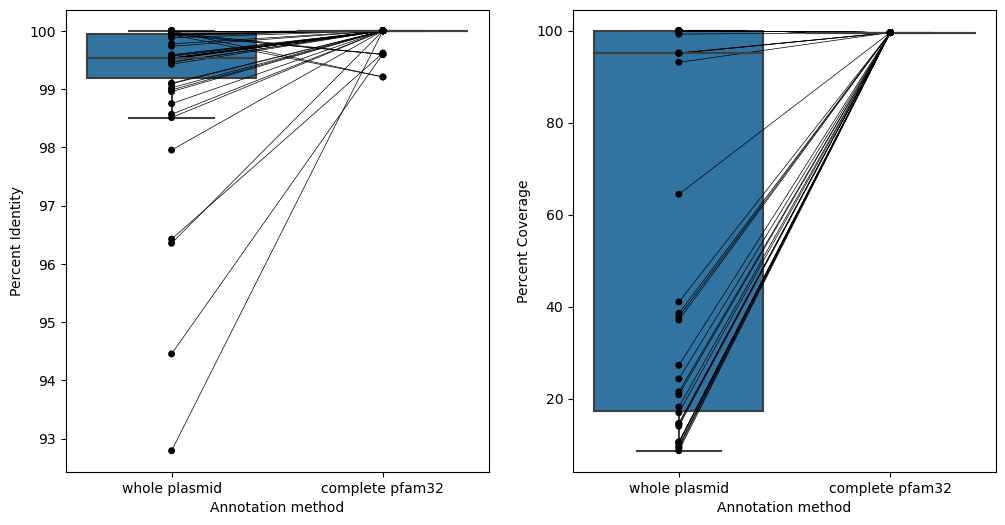

In [73]:
temp1 = group4.melt(id_vars=['name', 'contig'], 
                   value_vars=['wp_percent_identity', 'pf_percent_identity'], 
                   var_name='Annotation method', 
                   value_name='Percent Identity')
temp1['Annotation method'] = temp1['Annotation method'].apply(lambda x: 'whole plasmid' if 'wp' in x else 'complete pfam32')

temp2 = group4.melt(id_vars=['name', 'contig'], 
                   value_vars=['wp_coverage_percentage', 'pf_coverage_percentage'], 
                   var_name='Annotation method', 
                   value_name='Percent Coverage')
temp2['Annotation method'] = temp2['Annotation method'].apply(lambda x: 'whole plasmid' if 'wp' in x else 'complete pfam32')

temp = pd.merge(temp1, temp2, on=['name', 'contig', 'Annotation method'])

temp = temp.melt(id_vars=['name', 'contig', 'Annotation method'],
                 value_vars=['Percent Identity', 'Percent Coverage'],
                 var_name='Metric',
                 value_name='Value')
temp.sort_values(by=['name', 'contig', 'Annotation method', 'Metric', 'Value'])


fig, axes = plt.subplots(1, 2, figsize=(12,6))
ax = axes[0]
sns.boxplot(x='Annotation method',
            y='Percent Identity',
            data=temp1,
            showfliers=False,
            ax=ax)
sns.stripplot(x='Annotation method',
            y='Percent Identity',
            data=temp1,
            jitter=False,
            color='black',
            ax=ax)
for _, row in temp1[['name','contig']].drop_duplicates().iterrows():
    y1=temp1[
        (temp1['name']==row['name']) & 
        (temp1['contig']==row['contig']) & 
        (temp1['Annotation method']=='whole plasmid')]['Percent Identity'].item()
    y2=temp1[
        (temp1['name']==row['name']) & 
        (temp1['contig']==row['contig']) & 
        (temp1['Annotation method']=='complete pfam32')]['Percent Identity'].item()
    ax.plot([0, 1], [y1, y2], linestyle='-', color='black', linewidth=0.5)
ax = axes[1]
sns.boxplot(x='Annotation method',
            y='Percent Coverage',
            data=temp2,
            showfliers=False,
            ax=ax)
sns.stripplot(x='Annotation method',
            y='Percent Coverage',
            data=temp2,
            jitter=False,
            color='black',
            ax=ax);
for _, row in temp2[['name','contig']].drop_duplicates().iterrows():
    y1=temp2[
        (temp2['name']==row['name']) & 
        (temp2['contig']==row['contig']) & 
        (temp2['Annotation method']=='whole plasmid')]['Percent Coverage'].item()
    y2=temp2[
        (temp2['name']==row['name']) & 
        (temp2['contig']==row['contig']) & 
        (temp2['Annotation method']=='complete pfam32')]['Percent Coverage'].item()
    ax.plot([0, 1], [y1, y2], linestyle='-', color='black', linewidth=0.5)

In [99]:
group4[group4['pf_plasmid_name']=='cp32-4'
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,URI87,2916,cp32-4,cp32-9-4,cp32-4,100.000000,9.620780,100.0,99.601594
1,URI40,2916,cp32-4,cp32-9-4,cp32-4,99.931413,9.620780,100.0,99.601594
2,URI107,3189,cp32-4,cp32-9-4,cp32-4,100.000000,10.521799,100.0,99.601594
3,URI102,3189,cp32-4,cp32-9-4,cp32-4,100.000000,10.521799,100.0,99.601594
4,URI101,3215,cp32-4,cp32-9-4,cp32-4,99.937792,10.607611,100.0,99.601594
5,URI93,6954,cp32-4,cp32-9-4,cp32-4,98.954231,24.294531,100.0,99.601594
6,UCT109,7857,cp32-4,cp32-9-4,cp32-4,98.983789,27.274828,100.0,99.601594
7,UCT96H,30375,cp32-4,cp32-9-4,cp32-4,98.566297,99.264002,100.0,99.601594
8,UCT31H,30299,cp32-4,cp32-9-4,cp32-4,99.514735,99.993399,100.0,99.601594
9,URI107H,30299,cp32-4,cp32-9-4,cp32-4,99.521162,99.993399,100.0,99.601594


In [100]:
group4[group4['pf_plasmid_name']=='cp32-1'
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,URI89H,2674,cp32-1,cp32-5-1,cp32-1,100.000000,8.692683,100.000000,99.593496
1,UCT96,2812,cp32-1,cp32-5-1,cp32-1,100.000000,9.141463,100.000000,99.593496
2,UWI283,3152,cp32-1,cp32-5-1,cp32-1,98.509356,10.206262,100.000000,99.593496
3,UCT29,4313,cp32-1,cp32-5-1,cp32-1,98.748552,14.013008,100.000000,99.593496
4,URI91,4440,cp32-1,cp32-5-1,cp32-1,99.774775,14.435772,100.000000,99.593496
5,URI89,4467,cp32-1,cp32-5-1,cp32-1,99.955227,14.523577,100.000000,99.593496
6,UCT31,5212,cp32-1,cp32-5-1,cp32-1,99.424405,16.946341,100.000000,99.593496
7,UNY208,2711,cp32-1,cp32-5-1,cp32-1,99.926226,18.208694,100.000000,99.593496
8,UWI247,3106,cp32-1,cp32-5-1,cp32-1,99.935608,20.862729,99.593496,99.593496
9,UWI248,3202,cp32-1,cp32-5-1,cp32-1,99.937539,21.507761,99.593496,99.593496


In [101]:
group4[(group4['pf_plasmid_name']!='cp32-1') & (group4['pf_plasmid_name']!='cp32-4')
      ][['name', 'contig_len', 'wp_plasmid_name', 
        'all_pf_plasmid_name', 'pf_plasmid_name', 
        'wp_percent_identity', 'wp_coverage_percentage', 
        'pf_percent_identity', 'pf_coverage_percentage']].sort_values(by=['pf_plasmid_name', 'wp_plasmid_name', 'wp_coverage_percentage']).reset_index(drop=True)

,name,contig_len,wp_plasmid_name,all_pf_plasmid_name,pf_plasmid_name,wp_percent_identity,wp_coverage_percentage,pf_percent_identity,pf_coverage_percentage
0,UWI263P,29792,cp32-10,lp56,cp32-10,94.453444,93.128587,99.601594,99.601594
1,URI36,4424,cp32-11,cp32-1,cp32-11,99.932188,14.657344,99.206349,99.603175
2,URI36H,30176,cp32-11,cp32-1,cp32-11,99.993372,99.993372,99.206349,99.603175
3,URI56H,3150,lp21,lp21-cp9,lp21,96.424198,37.790914,99.618321,99.618321
4,UCT30H,52259,lp28-5,lp28-1,lp28-5,97.951771,95.088143,100.000000,99.591837
5,URI112H,44674,lp28-5,lp38,lp28-5,99.021650,95.088143,100.000000,99.591837


#### Sanity check

In [102]:
print(len(df))
print(len(group1) + len(group2) + len(group3) + len(group4))

239
239


### Examination of plasmid pfam test sets

In [138]:
with open('all_pf32_genes.fasta', 'r') as f:
    all_pf_text = f.readlines()
all_pf_genes = [l[1:-1] for l in all_pf_text if '>' in l]
all_pf_plasmids = [g.split('_ParA')[0] for g in all_pf_genes]
all_pf_plasmids = [p.rsplit('_', 1)[1] for p in all_pf_plasmids]
all_pf_plasmids = set(all_pf_plasmids)

with open('Minimal-PF32-testor-set-March2021.faa', 'r') as f:
    min_pf_text = f.readlines()
min_pf_genes = [l[1:-1] for l in min_pf_text if '>' in l]
min_pf_plasmids = [g.rsplit('_',1)[1] for g in min_pf_genes]
min_pf_plasmids = [p for p in min_pf_plasmids if p.startswith('lp') or p.startswith('cp')]
min_pf_plasmids = set(min_pf_plasmids)


all_pf_plasmids - min_pf_plasmids

{'chromosome',
 'cp32-1+5',
 'cp32-2',
 'cp32-3+10',
 'cp32-5+1',
 'cp32-5-1',
 'cp32-9-4',
 'lp21-cp9',
 'lp28-11'}